# Transfer learning with `braai`

`20200211` nb status: unfinished

We will fine-tune `braai` with transfer learning using the ZUDS survey as an example.

In [33]:
from astropy.io import fits
from astropy.visualization import ZScaleInterval
from bson.json_util import loads, dumps
import gzip
import io
from IPython import display
import json
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
from penquins import Kowalski
import tensorflow as tf
from tensorflow.keras.models import model_from_json, load_model
from tensorflow.keras.utils import normalize as tf_norm
import os

In [2]:
plt.style.use(['dark_background'])
register_matplotlib_converters()
%matplotlib inline

In [3]:
def load_model_helper(path, model_base_name):
    """
        Build keras model using json-file with architecture and hdf5-file with weights
    """
    with open(os.path.join(path, f'{model_base_name}.architecture.json'), 'r') as json_file:
        loaded_model_json = json_file.read()
    m = model_from_json(loaded_model_json)
    m.load_weights(os.path.join(path, f'{model_base_name}.weights.h5'))

    return m

In [40]:
def make_triplet(alert, normalize: bool = False, old_norm: bool = False, to_tpu: bool = False):
    """
        Feed in alert packet
    """
    cutout_dict = dict()

    for cutout in ('science', 'template', 'difference'):
        cutout_data = loads(dumps([alert[f'cutout{cutout.capitalize()}']]))[0]

        # unzip
        with gzip.open(io.BytesIO(cutout_data), 'rb') as f:
            with fits.open(io.BytesIO(f.read())) as hdu:
                data = hdu[0].data
                # replace nans with zeros
                cutout_dict[cutout] = np.nan_to_num(data)
                # normalize
                if normalize:
                    if not old_norm:
                        cutout_dict[cutout] /= np.linalg.norm(cutout_dict[cutout])
                    else:
                        # model <= d6_m7
                        cutout_dict[cutout] = tf_norm(cutout_dict[cutout])

        # pad to 63x63 if smaller
        shape = cutout_dict[cutout].shape
        #print(shape)
        if shape != (63, 63):
            # print(f'Shape of {candid}/{cutout}: {shape}, padding to (63, 63)')
            cutout_dict[cutout] = np.pad(cutout_dict[cutout], [(0, 63 - shape[0]), (0, 63 - shape[1])],
                                         mode='constant', constant_values=1e-9)

    triplet = np.zeros((63, 63, 3))
    triplet[:, :, 0] = cutout_dict['science']
    triplet[:, :, 1] = cutout_dict['template']
    triplet[:, :, 2] = cutout_dict['difference']
    
    if to_tpu:
        # Edge TPUs require additional processing
        triplet = np.rint(triplet * 128 + 128).astype(np.uint8).flatten()
    
    return triplet

In [25]:
def plot_triplet(tr):
    fig = plt.figure(figsize=(8, 2), dpi=120)
    ax1 = fig.add_subplot(131)
    ax1.axis('off')
    interval = ZScaleInterval()
    limits = interval.get_limits(triplet[:, :, 0])
    # norm=LogNorm()
    ax1.imshow(tr[:, :, 0], origin='upper', cmap=plt.cm.bone, vmin=limits[0], vmax=limits[1])
    ax1.title.set_text('Science')
    ax2 = fig.add_subplot(132)
    ax2.axis('off')
    limits = interval.get_limits(triplet[:, :, 1])
    ax2.imshow(tr[:, :, 1], origin='upper', cmap=plt.cm.bone, vmin=limits[0], vmax=limits[1])
    ax2.title.set_text('Reference')
    ax3 = fig.add_subplot(133)
    ax3.axis('off')
    limits = interval.get_limits(triplet[:, :, 2])
    ax3.imshow(tr[:, :, 2], origin='upper', cmap=plt.cm.bone, vmin=limits[0], vmax=limits[1])
    ax3.title.set_text('Difference')
    plt.show()

## Kowalski

Get some example triplets from Kowalski

In [8]:
with open('secrets.json', 'r') as f:
    secrets = json.load(f)

In [9]:
k = Kowalski(username=secrets['kowalski']['username'], 
             password=secrets['kowalski']['password'])
connection_ok = k.check_connection()
print(f'Connection OK: {connection_ok}')

Connection OK: True


High `braai` version `d6_m9` scores:

In [11]:
q = {"query_type": "aggregate", 
     "query": {"catalog": "ZUDS_alerts", 
               "pipeline": [{'$match': {'classifications.braai': {'$gt': 0.9}}},
                            {'$project': {'candidate': 0, 'coordinates': 0}},
                            {'$sample': { 'size': 20 }}]
              }
    }
r = k.query(query=q)

high_braai = r['result_data']['query_result']

(61, 61)
(61, 61)
(61, 61)


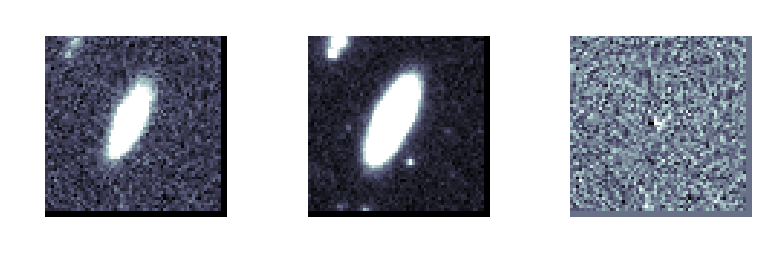

(61, 61)
(61, 61)
(61, 61)


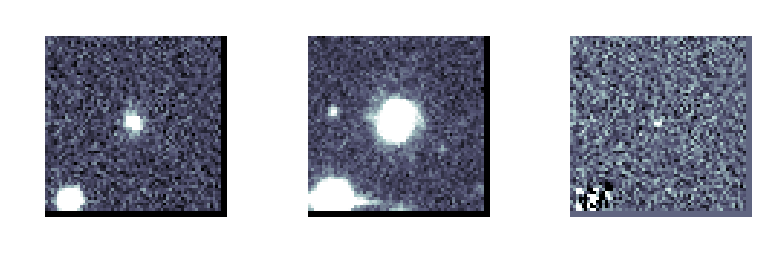

In [31]:
for alert in high_braai[-2:]:
    triplet = make_triplet(alert, normalize=True, old_norm=False)
    plot_triplet(triplet)

Low `braai` version `d6_m9` scores:

In [28]:
q = {"query_type": "aggregate", 
     "query": {"catalog": "ZUDS_alerts", 
               "pipeline": [{'$match': {'classifications.braai': {'$lt': 0.1}}},
                            {'$project': {'candidate': 0, 'coordinates': 0}},
                            {'$sample': { 'size': 20 }}]
              }
    }
r = k.query(query=q)

low_braai = r['result_data']['query_result']

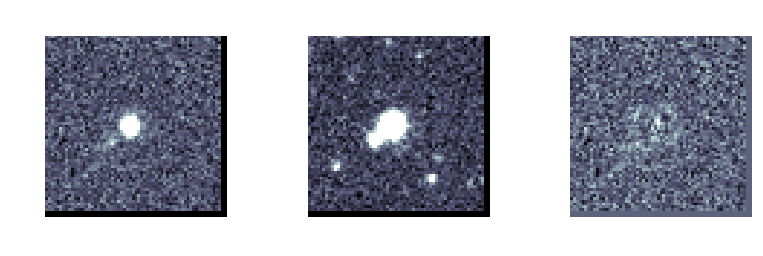

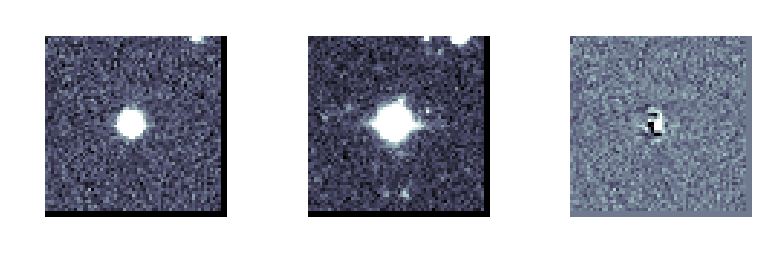

In [29]:
for alert in low_braai[-2:]:
    triplet = make_triplet(alert, normalize=True, old_norm=False)
    plot_triplet(triplet)

## Load the model

In [76]:
model = load_model_helper(path='../models', model_base_name='d6_m9')

In [77]:
# remove the output layer, leave the feature extraction part
model_fe = tf.keras.Model(inputs=model.inputs, outputs=model.layers[-2].output)

In [78]:
for alert in low_braai[-2:]:
    triplet = make_triplet(alert, normalize=True, old_norm=False)
    tr = np.expand_dims(triplet, axis=0)
    # get extracted features
    features = model_fe.predict(tr)
    print(features.shape)
#     print(features)

(1, 256)
(1, 256)


In [79]:
output = tf.keras.layers.Dense(1, activation='sigmoid')(model_fe.output)
model_tl = tf.keras.Model(inputs=model_fe.inputs, outputs=output)

In [80]:
# mark layers as not trainable
for layer in model_tl.layers[:-1]:
	layer.trainable = False

In [81]:
model_tl.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1_input (InputLayer)     [(None, 63, 63, 3)]       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 61, 61, 16)        448       
_________________________________________________________________
conv2 (Conv2D)               (None, 59, 59, 16)        2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 29, 29, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 29, 29, 16)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 27, 27, 32)        4640      
_________________________________________________________________
conv4 (Conv2D)               (None, 25, 25, 32)        9248